In [9]:
!apt-get install unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
import os
import zipfile

# Define the ZIP file path and extraction directory
zip_path = "DataSet.zip"        # change if your file is in another location
extract_to = "dataset"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# List extracted files to verify
print(f"Files extracted to: {extract_to}")
print(os.listdir(extract_to))


Files extracted to: dataset
['Augmentedsrc', 'Augmentedmask']


In [3]:
import os
import pandas as pd

# Define the paths to the image and mask directories
image_dir = "dataset/Augmentedsrc"
mask_dir = "dataset/Augmentedmask"

# List and sort all image and mask files for consistent mapping
image_files = sorted(os.listdir(image_dir))  # Sorting ensures correct pair matching
mask_files = sorted(os.listdir(mask_dir))   # Sorting ensures correct pair matching

# Verify that the number of images matches the number of masks
if len(image_files) != len(mask_files):
    print(f"Warning: Number of images ({len(image_files)}) and masks ({len(mask_files)}) do not match!")
else:
    print(f"Number of images and masks: {len(image_files)}")

# Ensure consistent file matching by filename (if applicable)
for img, msk in zip(image_files, mask_files):
    if os.path.splitext(img)[0] != os.path.splitext(msk)[0]:
        print(f"Mismatch detected: {img} does not match {msk}")

# Create file paths
image_paths = [os.path.join(image_dir, img) for img in image_files]
mask_paths = [os.path.join(mask_dir, msk) for msk in mask_files]

# Create separate DataFrames for images and masks
image_df = pd.DataFrame({"ImagePath": image_paths})
mask_df = pd.DataFrame({"MaskPath": mask_paths})

# Save the DataFrames to separate CSV files
image_csv_path = "image_paths.csv"
mask_csv_path = "mask_paths.csv"

image_df.to_csv(image_csv_path, index=False, header=False)
mask_df.to_csv(mask_csv_path, index=False, header=False)

print(f"Image CSV file created at: {image_csv_path}")
print(f"Mask CSV file created at: {mask_csv_path}")

# Preview the first few rows of each CSV
print("Image paths preview:")
print(image_df.head())

print("Mask paths preview:")
print(mask_df.head())


Number of images and masks: 29940
Image CSV file created at: image_paths.csv
Mask CSV file created at: mask_paths.csv
Image paths preview:
                       ImagePath
0   dataset/Augmentedsrc/0_1.png
1  dataset/Augmentedsrc/0_10.png
2  dataset/Augmentedsrc/0_11.png
3  dataset/Augmentedsrc/0_12.png
4  dataset/Augmentedsrc/0_13.png
Mask paths preview:
                         MaskPath
0   dataset/Augmentedmask/0_1.png
1  dataset/Augmentedmask/0_10.png
2  dataset/Augmentedmask/0_11.png
3  dataset/Augmentedmask/0_12.png
4  dataset/Augmentedmask/0_13.png


In [11]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf

# =====================================
# 📊 SAME CSV INPUT PIPELINE
# =====================================

# Load the CSVs without headers
x_train_paths = pd.read_csv(r'image_paths.csv', header=None)[0]
y_train_paths = pd.read_csv(r'mask_paths.csv', header=None)[0]

# Preprocess data functions (SAME as before)
def preprocess_image(img_path):
    """Preprocess input image: resize, normalize, and add channel dimension."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))  # Resize to model's input size
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

def preprocess_mask(mask_path):
    """Preprocess mask: resize, normalize, and add channel dimension."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

# 🚀 ENHANCED GENERATOR FOR DEEP SUPERVISION (Multiple Outputs)
def dag_image_mask_generator(image_paths, mask_paths, batch_size=8):
    """
    Enhanced generator for DAG-VNet with deep supervision.
    Returns same mask for all three outputs (main, aux1, aux2)
    """
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_image_paths = image_paths[i:i+batch_size]
            batch_mask_paths = mask_paths[i:i+batch_size]
            
            # Preprocess batch of images and masks
            batch_images = np.array([preprocess_image(path) for path in batch_image_paths])
            batch_masks = np.array([preprocess_mask(path) for path in batch_mask_paths])
            
            # For deep supervision: same mask for all three outputs
            yield batch_images, {
                "main_output": batch_masks,
                "aux_output_1": batch_masks,  # Same mask, different scales
                "aux_output_2": batch_masks
            }

# =====================================
# 🧠 TRUE DAG-VNET MODEL ARCHITECTURE
# =====================================

def residual_block(x, filters, kernel_size=(3, 3)):
    """V-Net style residual block"""
    shortcut = x
    
    # First conv
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Second conv
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Adjust shortcut dimensions if needed
    if shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, (1, 1), padding="same")(shortcut)
    
    # Add residual connection
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    
    return x

def dag_multi_scale_fusion(feature_maps, target_filters):
    """True DAG fusion with attention, dynamic resizing."""
    target_h = tf.shape(feature_maps[0])[1]
    target_w = tf.shape(feature_maps[0])[2]

    resized_features = []
    for fm in feature_maps:
        fm_resized = tf.image.resize(fm, (target_h, target_w), method="bilinear")
        fm_resized = tf.keras.layers.Conv2D(
            target_filters // len(feature_maps), (1, 1), padding="same"
        )(fm_resized)
        resized_features.append(fm_resized)

    merged = tf.keras.layers.Concatenate()(resized_features)
    attention = tf.keras.layers.Conv2D(target_filters, (1, 1), activation="sigmoid")(merged)
    fused = tf.keras.layers.Multiply()([merged, attention])
    output = tf.keras.layers.Conv2D(target_filters, (3, 3), padding="same")(fused)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.ReLU()(output)
    return output


def true_dag_vnet(input_shape=(256, 256, 1), num_classes=1):
    """
    True DAG-VNet with V-Net backbone and complex DAG connections
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder with residual blocks (V-Net style)
    # Level 1
    e1 = residual_block(inputs, 32)
    e1 = residual_block(e1, 32)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(e1)
    
    # Level 2  
    e2 = residual_block(p1, 64)
    e2 = residual_block(e2, 64)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(e2)
    
    # Level 3
    e3 = residual_block(p2, 128)
    e3 = residual_block(e3, 128)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(e3)
    
    # Level 4
    e4 = residual_block(p3, 256)
    e4 = residual_block(e4, 256)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(e4)
    
    # Bottleneck
    bottleneck = residual_block(p4, 512)
    bottleneck = residual_block(bottleneck, 512)
    
    # Decoder with true DAG connections
    # Level 4 decoder - connects to all encoder levels
    u4 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(bottleneck)
    d4 = dag_multi_scale_fusion([u4, e4], 256)  # Start with fewer connections to avoid complexity
    d4 = residual_block(d4, 256)
    
    # Level 3 decoder - connects to multiple levels including previous decoder
    u3 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(d4)
    d3 = dag_multi_scale_fusion([u3, e3], 128)
    d3 = residual_block(d3, 128)
    
    # Level 2 decoder
    u2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(d3)
    d2 = dag_multi_scale_fusion([u2, e2], 64)
    d2 = residual_block(d2, 64)
    
    # Level 1 decoder
    u1 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(d2)
    d1 = dag_multi_scale_fusion([u1, e1], 32)
    d1 = residual_block(d1, 32)
    
    # Output with deep supervision (another DAG concept)
    # Multiple output heads for different scales
    out_main = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="sigmoid", name="main_output")(d1)
    
    # Deep supervision outputs (optional)
    out_aux1 = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="sigmoid", name="aux_output_1")(
        tf.keras.layers.UpSampling2D((2, 2))(d2)
    )
    out_aux2 = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="sigmoid", name="aux_output_2")(
        tf.keras.layers.UpSampling2D((4, 4))(d3)
    )
    
    model = tf.keras.models.Model(
        inputs=inputs, 
        outputs=[out_main, out_aux1, out_aux2],
        name="True_DAG_VNet"
    )
    
    return model

# =====================================
# 🚀 MODEL CREATION AND COMPILATION
# =====================================

# Create the generator for training data
train_generator = dag_image_mask_generator(x_train_paths, y_train_paths, batch_size=8)

# Create and compile true DAG-VNet
model = true_dag_vnet(input_shape=(256, 256, 1), num_classes=1)

# Custom loss for deep supervision
def dag_combined_loss(y_true, y_pred):
    """Combined loss for main and auxiliary outputs"""
    main_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred[0])
    aux_loss1 = tf.keras.losses.binary_crossentropy(y_true, y_pred[1]) 
    aux_loss2 = tf.keras.losses.binary_crossentropy(y_true, y_pred[2])
    
    # Weighted combination
    total_loss = main_loss + 0.5 * aux_loss1 + 0.25 * aux_loss2
    return total_loss

# Compile model with multiple outputs
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "main_output": "binary_crossentropy",
        "aux_output_1": "binary_crossentropy", 
        "aux_output_2": "binary_crossentropy"
    },
    loss_weights={
        "main_output": 1.0,
        "aux_output_1": 0.5,
        "aux_output_2": 0.25
    },
    metrics=["accuracy"]
)

# Model summary
print("🧠 True DAG-VNet Model Summary:")
model.summary()



🧠 True DAG-VNet Model Summary:
Model: "True_DAG_VNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_98 (Conv2D)          (None, 256, 256, 32)         320       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_64 (Ba  (None, 256, 256, 32)         128       ['conv2d_98[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_64 (ReLU)             (None, 256, 256, 32)      

In [ ]:

# =====================================
# 🏋️ TRAINING THE MODEL
# =====================================

print("\n🚀 Starting Training...")
print(f"📊 Total training samples: {len(x_train_paths)}")
print(f"📦 Batch size: 8")
print(f"📈 Steps per epoch: {len(x_train_paths) // 8}")

# Train the model using the batch generator
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train_paths) // 8,
    epochs=25,
    verbose=1
)

# After training your model
import tensorflow as tf

# 1. Save in .keras format (new Keras native format)
model.save("True_DAG_VNet_model.keras")

# 2. Save in HDF5 (.h5) format (older, widely supported)
model.save("True_DAG_VNet_model.h5")

# 3. Save in TensorFlow SavedModel directory format (most portable)
model.save("True_DAG_VNet_savedmodel", save_format="tf")

# 4. Explicit TensorFlow SavedModel export (alternative API)
tf.saved_model.save(model, "True_DAG_VNet_tf_format")

print("\n✅ Training completed successfully!")
print("💾 Model saved in formats: .keras, .h5, SavedModel folder, and tf_format")

import tensorflow as tf

print("TensorFlow version:", tf.__version__)

try:
    import keras
    print("Keras version:", keras.__version__)
except ImportError:
    print("Keras not installed")

try:
    import tf_keras
    print("tf_keras version:", tf_keras.__version__)
except ImportError:
    print("tf_keras not installed, using tf.keras instead")




🚀 Starting Training...
📊 Total training samples: 29940
📦 Batch size: 8
📈 Steps per epoch: 3742
Epoch 1/25
3742/3742 [==============================] - 510s 130ms/step - loss: 0.5314 - main_output_loss: 0.3026 - aux_output_1_loss: 0.3037 - aux_output_2_loss: 0.3078 - main_output_accuracy: 0.8630 - aux_output_1_accuracy: 0.8616 - aux_output_2_accuracy: 0.8605
Epoch 2/25
3742/3742 [==============================] - 489s 130ms/step - loss: 0.5029 - main_output_loss: 0.2869 - aux_output_1_loss: 0.2873 - aux_output_2_loss: 0.2894 - main_output_accuracy: 0.8702 - aux_output_1_accuracy: 0.8688 - aux_output_2_accuracy: 0.8677
Epoch 3/25
3742/3742 [==============================] - 487s 130ms/step - loss: 0.4958 - main_output_loss: 0.2827 - aux_output_1_loss: 0.2837 - aux_output_2_loss: 0.2849 - main_output_accuracy: 0.8714 - aux_output_1_accuracy: 0.8702 - aux_output_2_accuracy: 0.8695
Epoch 4/25
3742/3742 [==============================] - 487s 130ms/step - loss: 0.4924 - main_output_loss: 0.

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: True_DAG_VNet_savedmodel/assets


INFO:tensorflow:Assets written to: True_DAG_VNet_savedmodel/assets


INFO:tensorflow:Assets written to: True_DAG_VNet_tf_format/assets


INFO:tensorflow:Assets written to: True_DAG_VNet_tf_format/assets



✅ Training completed successfully!
💾 Model saved in formats: .keras, .h5, SavedModel folder, and tf_format
TensorFlow version: 2.16.2
Keras version: 3.11.3
tf_keras version: 2.16.0


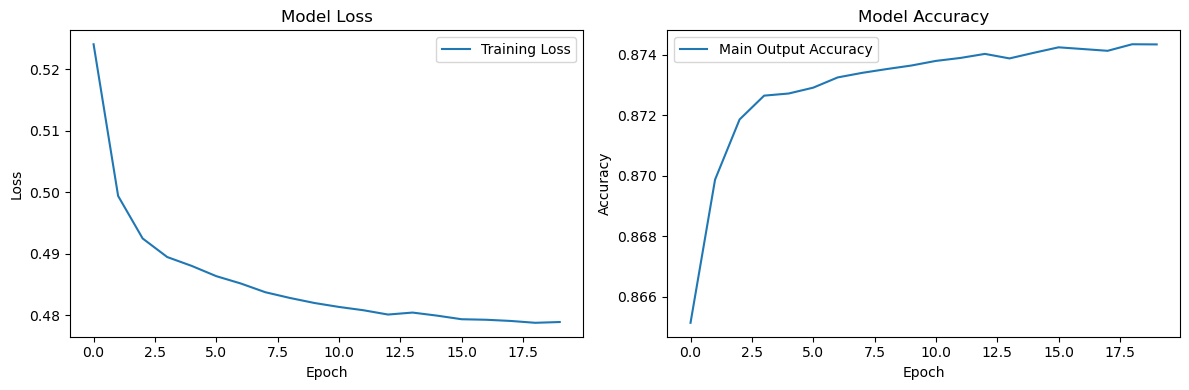


🎯 Ready for inference! Use the saved model for predictions.
💡 The model outputs 3 predictions: main_output (use this), aux_output_1, aux_output_2


In [15]:

# =====================================
# 🔍 OPTIONAL: VALIDATION SPLIT
# =====================================

def create_train_val_generators(image_paths, mask_paths, validation_split=0.2, batch_size=8):
    """Create training and validation generators with data split."""
    total_samples = len(image_paths)
    val_samples = int(total_samples * validation_split)
    
    # Shuffle indices
    indices = np.random.permutation(total_samples)
    
    # Split indices
    val_indices = indices[:val_samples]
    train_indices = indices[val_samples:]
    
    # Create splits
    x_train = image_paths.iloc[train_indices].reset_index(drop=True)
    y_train = mask_paths.iloc[train_indices].reset_index(drop=True)
    x_val = image_paths.iloc[val_indices].reset_index(drop=True)
    y_val = mask_paths.iloc[val_indices].reset_index(drop=True)
    
    # Create generators
    train_gen = dag_image_mask_generator(x_train, y_train, batch_size)
    val_gen = dag_image_mask_generator(x_val, y_val, batch_size)
    
    return train_gen, val_gen, len(x_train), len(x_val)

# Uncomment to use validation split:
"""
print("\n🔄 Creating train/validation split...")
train_gen, val_gen, train_samples, val_samples = create_train_val_generators(
    x_train_paths, y_train_paths, validation_split=0.2, batch_size=8
)

print(f"📊 Training samples: {train_samples}")
print(f"🔍 Validation samples: {val_samples}")

# Train with validation
history = model.fit(
    train_gen,
    steps_per_epoch=train_samples // 8,
    validation_data=val_gen,
    validation_steps=val_samples // 8,
    epochs=20,
    verbose=1
)
"""

# =====================================
# 📈 TRAINING VISUALIZATION (Optional)
# =====================================

import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['main_output_accuracy'], label='Main Output Accuracy')
if 'val_main_output_accuracy' in history.history:
    plt.plot(history.history['val_main_output_accuracy'], label='Val Main Output Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


print("\n🎯 Ready for inference! Use the saved model for predictions.")
print("💡 The model outputs 3 predictions: main_output (use this), aux_output_1, aux_output_2")

In [1]:
model.save('True_DAG_VNet_savedmodel', save_format='tf')

NameError: name 'model' is not defined

In [18]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

import tf_keras
print(tf_keras.__version__)



2.16.2
3.11.3
2.16.0


In [25]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Preprocess the input image: resize, normalize, and add a channel dimension.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

from skimage.measure import regionprops, label

def predict_and_calculate_head_circumference(image_path, model, target_size=(256, 256)):
    """
    Predict the segmentation mask for the given image and calculate head circumference.
    """
    # Preprocess the image
    image = preprocess_image(image_path, target_size)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict mask
    pred_mask = model.predict(image)[0, :, :, 0]  # Remove batch dimension
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binary thresholding

    # Label connected regions in the binary mask
    labeled_mask = label(pred_mask)
    regions = regionprops(labeled_mask)

    if regions:
        # Get the perimeter of the largest region (assuming it's the head region)
        largest_region = max(regions, key=lambda r: r.area)
        circumference = largest_region.perimeter
        return circumference
    else:
        print("No region detected!")
        return 0
